In [1]:
import numpy as np
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt
import h5py
#from numpy import sin, cos, exp, sqrt, pi
#from scipy.sparse import diags, spdiags, identity, kron
#from scipy.sparse.linalg import eigsh

import os
from os import listdir
from os.path import isfile, isdir, join
from itertools import product

import time

In [2]:
instance = "styblinski_tang"
QHD_DATA_PATH = "/Users/ethan/LocalResearchData/HamiltonianDescent/QHD_DATA/NonCVX-2D"
DATA_DIR = join(QHD_DATA_PATH, f"{instance}")
QHD_WFN_DIR = join(DATA_DIR, f"{instance}_QHD_WFN")

In [3]:
def get_sample(coord_list, dist, numruns):    
    buffer = random.choices(coord_list, weights=dist, k=numruns)
    samples = np.zeros((numruns, 2))
    for j in range(numruns):
        samples[j] = buffer[j]
    return samples

# Binary search for index of closest element to desired
def bin_search(target, arr):
    low = 0
    high = len(arr)-1
    if target <= arr[low]:
        return low
    if target >= arr[high]:
        return high
    
    while high - low > 1:

        mid = low + (high - low) // 2
        mid_value = arr[mid]
                
        if target == mid_value:
            return mid
        if target > mid_value:
            low = mid
        if target < mid_value:
            high = mid
            
    if abs(target - arr[low]) <= abs(target - arr[high]):
        return low
    
    return high

assert bin_search(30.9, list(range(32))) == 31
assert bin_search(30.1, list(range(32))) == 30
assert bin_search(30, list(range(32))) == 30
assert bin_search(11, 2.5*np.array(range(32))) == 4

In [4]:
# QHD Setup
steps = 256
rez = 1 / steps
cells = np.linspace(0,1-rez, steps)
qhd_coord_list = []
for i,j in product(cells, cells):
    qhd_coord_list.append([i,j])

In [5]:
# QAA Setup
adb_steps = 64
dx = 1/(adb_steps+1)
adb_cells = np.linspace(dx, 1-dx, adb_steps)
qaa_coord_list = []

for i,j in product(adb_cells, adb_cells):
    qaa_coord_list.append([i,j])
    
QAA_DATA = {}
filepath = join(DATA_DIR, f"{instance}_QAA_T500.mat")
f = h5py.File(filepath)
for k, v in f.items():
    QAA_DATA[k] = np.array(v)

qaa_times = QAA_DATA["snapshot_times"][0]
qaa_wfn = QAA_DATA["wfn"].view(np.complex128)

In [6]:
# CHD Setup
CHD_DATA = {}
loadmat(join(DATA_DIR, f"{instance}_CHD.mat"), mdict=CHD_DATA)
chd_times = CHD_DATA['times'][0][0][0]
chd_paths = CHD_DATA['positions']

In [7]:
# SGD Setup
ALPHA = 0.01

SGD_DATA = {}
loadmat(join(DATA_DIR, f"{instance}_NGD.mat"), mdict=SGD_DATA)
sgd_paths = SGD_DATA['ngd_positions']

def build_sgd_times(end_time=None, num_steps=None):
    times = [0]

    time = 0
    step_count = 0
    
    if end_time is None and num_steps is None:
        return []
        
    if end_time is not None and num_steps is None:
        condition = lambda time, step_count : time < end_time
    elif steps is not None and end_time is None:
        condition = lambda time, step_count : step_count < num_steps-1
        
    if end_time is None and num_steps is None:
        raise(ValueError, "Pick max time or number of steps")
    
    while condition(time, step_count):
        time += ALPHA/(1 + ALPHA*step_count)
        times.append(time)
        step_count += 1
        
#     if end_time is not None:
#         while time < end_time:
#             time += ALPHA/(1 + ALPHA*step_count)
#             times.append(time)
#             step_count += 1
#     elif steps is not None:
#         while step_count < num_steps-1:
#             time += ALPHA/(1 + ALPHA*step_count)
#             times.append(time)
#             step_count += 1
    
    return times

sgd_times = build_sgd_times(num_steps=np.max(SGD_DATA["ngd_last_frame"]))
print(len(sgd_times))

10000


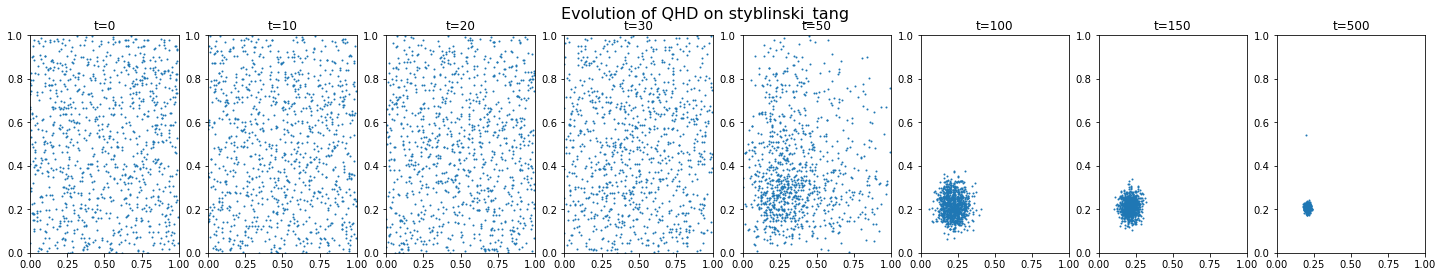

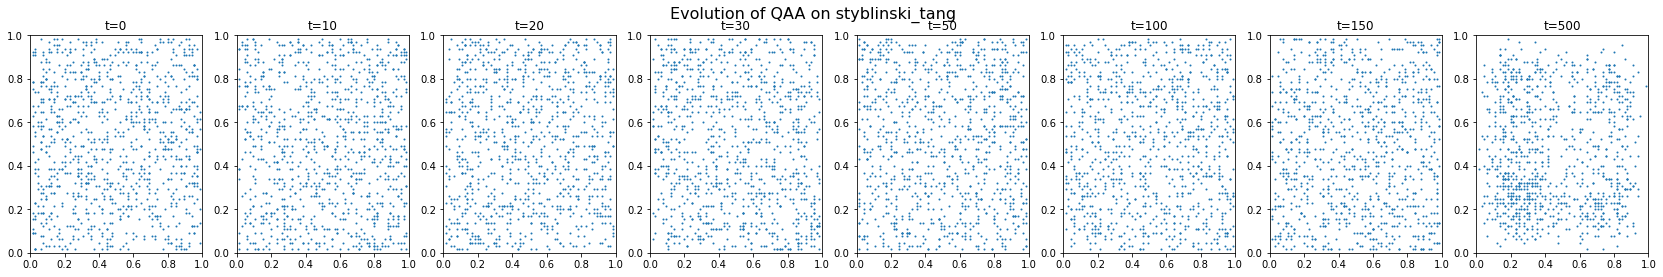

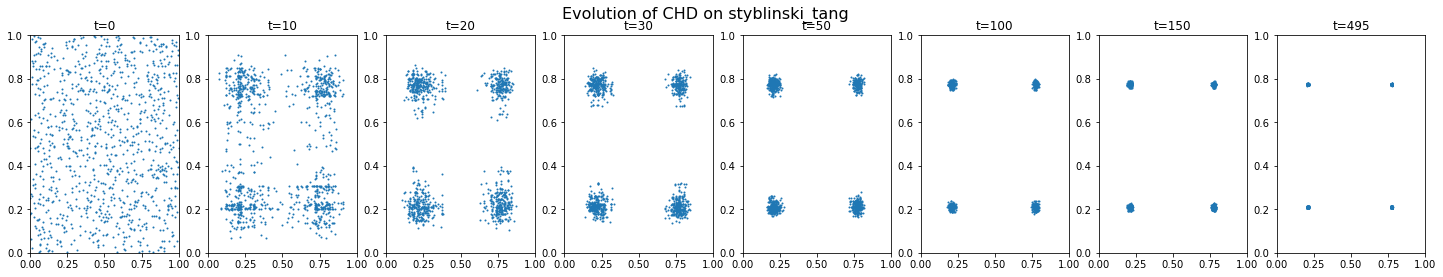

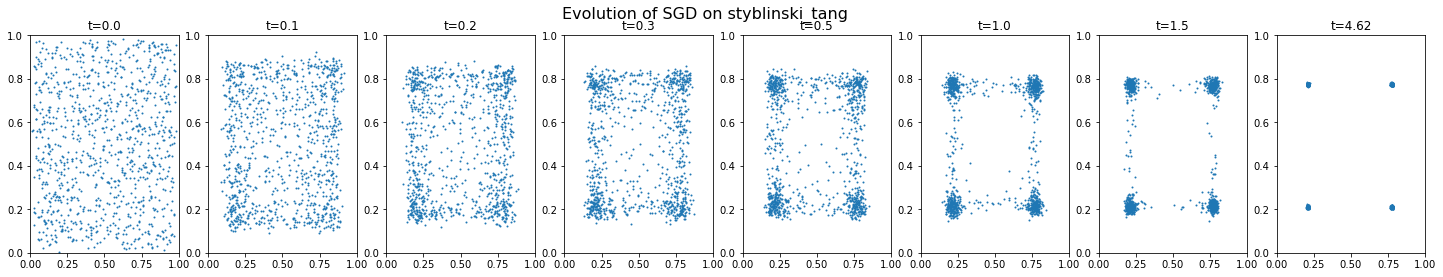

In [8]:
# QHD Plot
requested_frame_times = np.array([0, 10, 20, 30, 50, 100, 150, 500])
numruns = 1000
n_plots = len(requested_frame_times)

fig, axs = plt.subplots(1, n_plots, figsize=(25,4))

fig.suptitle(f'Evolution of QHD on {instance}', fontsize=16)
for j in range(n_plots):
    snapshot_time = requested_frame_times[j]
    
    if snapshot_time == 0:
        wfn_fname = "psi_0.npy"
    else:
        wfn_fname = f"psi_{int(10*snapshot_time)}e-01.npy"
    
    psi = np.load(os.path.join(QHD_WFN_DIR, wfn_fname))
    qhd_prob = (psi * psi.conj()).real.flatten('F')
    samples = get_sample(qhd_coord_list, qhd_prob, numruns)
    
    axs[j].scatter(samples[:,0], samples[:,1],s=1)
    
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={snapshot_time}")

plt.show()

    
# QAA Plot
qaa_frames = [bin_search(t, qaa_times) for t in requested_frame_times]
qaa_frame_times = [qaa_times[qaa_t] for qaa_t in qaa_frames]

fig, axs = plt.subplots(1, len(qaa_frames), figsize=(29,4))

fig.suptitle(f'Evolution of QAA on {instance}', fontsize=16)
for j in range(n_plots):
    frame_idx = qaa_frames[j]
    wfn_frame = qaa_wfn[:,frame_idx]
    qaa_prob = (wfn_frame * np.conj(wfn_frame)).real
    samples = get_sample(qaa_coord_list, qaa_prob, numruns)
    
    axs[j].scatter(samples[:,0], samples[:,1],s=1)
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={int(np.round(qaa_frame_times[j]))}")

plt.show()


# CHD Plot
chd_frames = [bin_search(t, chd_times) for t in requested_frame_times]

fig, axs = plt.subplots(1, n_plots, figsize=(25,4))

fig.suptitle(f'Evolution of CHD on {instance}', fontsize=16)
for j in range(n_plots):
    frame_idx = chd_frames[j]
    samples = np.zeros((numruns, 2))
    for k in range(numruns):
        samples[k,:] = chd_paths[k][0][frame_idx]
    axs[j].scatter(samples[:,0], samples[:,1],s=1)
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={int(chd_times[frame_idx])}")

plt.show()


# SGD Plot
requested_sgd_times = ALPHA * requested_frame_times
sgd_frames = [bin_search(t, sgd_times) for t in requested_sgd_times]

fig, axs = plt.subplots(1, n_plots, figsize=(25,4))

fig.suptitle(f'Evolution of SGD on {instance}', fontsize=16)
for j in range(n_plots):
    frame = sgd_frames[j]
    
    axs[j].scatter(sgd_paths[:,frame,0], sgd_paths[:,frame,1],s=1)
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={np.round(100*sgd_times[sgd_frames[j]])/100}")